# Is an SMS Spam? Using Word Count, Character Count and XGBoost

**Problem**: Given a text message, we would like to predict whether it is spam or whether it is not spam (ham).

In this notebook we will look at the character count, word count and word frequency of messages in the dataset and use them as features to predict whether a message is spam or not.

**Using only word count and character count, we achieve a test accuracy of 91%.**

**Using the 25 most common words in spam and ham messages, we achieve a test accuracy of 100% (likely rounded).**

* This is surprising so I am looking into potential problems with implementation. The current version counts only the most frequent words in the training set, but this still produces a test accuracy of 100%.

If you found this helpful, do upvote or leave a comment! Likewise do post suggestions.

*[Data by UCI Machine Learning, posted on Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset)*

*Credits to [anokas's Quora questions kernel](https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb) for inspiring many of these methods.*

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print("Data files:")
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

Data files:
spam.csv



## Read in and preview data

In [2]:
# Read in data
df = pd.read_csv('../input/spam.csv', encoding='latin-1')

# Preview data
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Drop redundant columns and rename columns so the titles are meaningful
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
# Note: if you rename 'v2' as something like 'text', be sure not to
# overwrite the column when you create words as features (and so) 
# have columns named 'text' later on!
df = df.rename(columns={"v1":"label", "v2":"sms_text"})
df.head()

,label,sms_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# How many spam messages are there?
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
print(round(747 / (747 + 4825) * 100, 2), "% of messages in our dataset are spam.")

13.41 % of messages in our dataset are spam.


## Character Count
Let's plot the character count for all messages, and then for ham vs spam messages.

In [6]:
# Character count

# Each line of code creates a list of messages, saving each message as a string.

# We want three lists: one with all messages in them, one with only ham messages 
# and one with only spam messages.
messages = pd.Series(df['sms_text'].tolist()).astype(str)
ham_messages = pd.Series(df[df['label'] == 'ham']['sms_text'].tolist()).astype(str)
spam_messages = pd.Series(df[df['label'] == 'spam']['sms_text'].tolist()).astype(str)

# Create the corresponding distribution of character counts for each list.
# We count the number of characters in each message using the `len` function.
dist_all = messages.apply(len)
dist_ham = ham_messages.apply(len)
dist_spam = spam_messages.apply(len)

# Summary statistics for character count of all messages
mean-all 80.12 
std-all 59.69 
min-all 2.00 
max-all 910.00


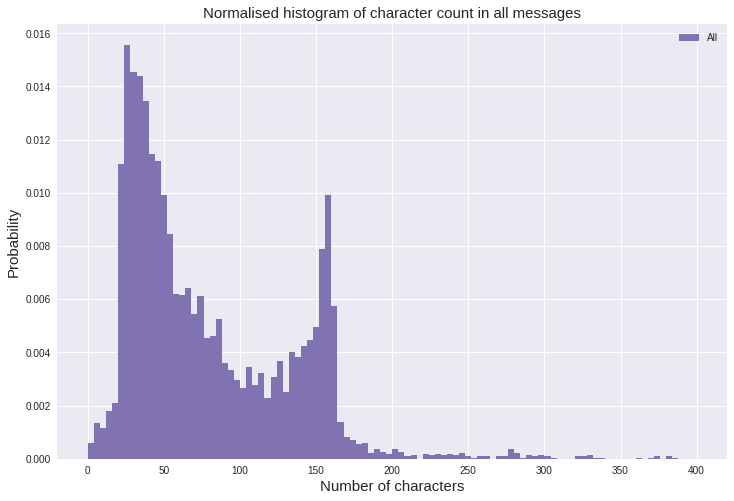

In [7]:
# Plot distribution of character count of all messages

plt.figure(figsize=(12, 8))
plt.hist(dist_all, bins=100, range=[0,400], color=pal[3], normed=True, label='All')
plt.title('Normalised histogram of character count in all messages', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for character count of all messages')
print('mean-all {:.2f} \nstd-all {:.2f} \nmin-all {:.2f} \nmax-all {:.2f}'.format(dist_all.mean(), 
                          dist_all.std(), dist_all.min(), dist_all.max()))

The distribution of characters seems bimodal (two-peaked), with most messages having between 0 and 200 characters. There is a sharp decline after around 160 characters, which may be related to people being charged per SMS of 80 characters.

Now for the fun part: let's plot the character counts for spam vs ham messages separately.

# Summary statistics for character count of ham vs spam messages
mean-ham  71.02   mean-spam 138.87 
std-ham   58.02   std-spam   29.18 
min-ham    2.00   min-ham    13.00 
max-ham  910.00   max-spam  224.00


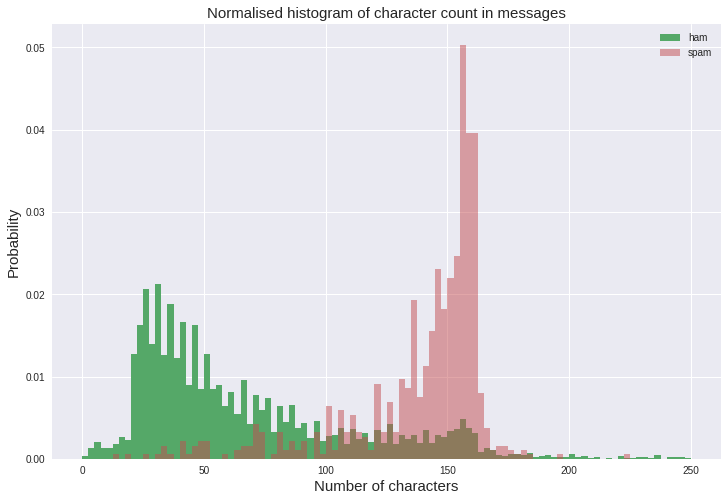

In [8]:
# Plot distributions of character counts for spam vs ham messages

plt.figure(figsize=(12,8))
plt.hist(dist_ham, bins=100, range=[0,250], color=pal[1], normed=True, label='ham')
plt.hist(dist_spam, bins=100, range=[0, 250], color=pal[2], normed=True, alpha=0.5, label='spam')
plt.title('Normalised histogram of character count in messages', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for character count of ham vs spam messages')
print('mean-ham  {:.2f}   mean-spam {:.2f} \nstd-ham   {:.2f}   std-spam   {:.2f} \nmin-ham    {:.2f}   min-ham    {:.2f} \nmax-ham  {:.2f}   max-spam  {:.2f}'.format(dist_ham.mean(), 
                         dist_spam.mean(), dist_ham.std(), dist_spam.std(), dist_ham.min(), dist_spam.min(), dist_ham.max(), dist_spam.max()))

Beautiful! The **character count seems to be a good predictor of  whether a message is spam or not**. Spam messages seem to have more characters on average than ham messages. In particular, there is a huge spike in spam messages between 130 and 162.5 characters. It's seems a bit too easy.

With ham messages between 25 and 90 characters, alternating bins also have significantly higher probabilities. I wonder why.

## Word Count

In [9]:
# Word Count

# We split each message into words using `.split(' ')`
# and count the number of words in each message using `len`.
dist_all = messages.apply(lambda x: len(x.split(' ')))
dist_ham = ham_messages.apply(lambda x: len(x.split(' ')))
dist_spam = spam_messages.apply(lambda x: len(x.split(' ')))

# Summary statistics for word count of all messages
mean-all 15.61 
std-all 11.42 
min-all 1.00 
max-all 171.00


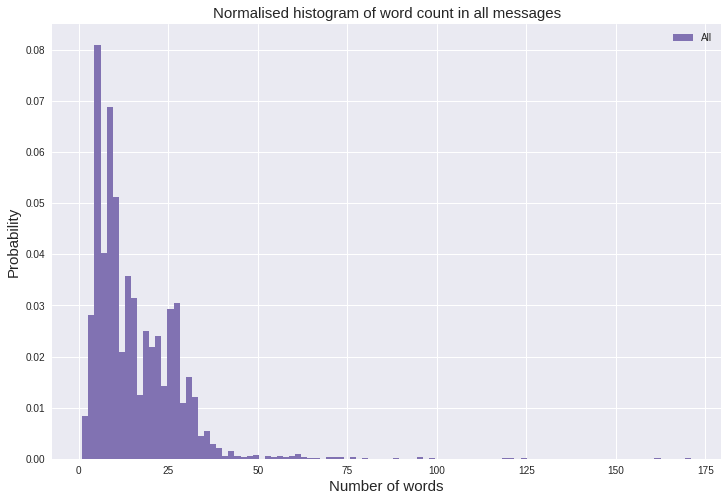

In [10]:
# Plot distribution of word count of all messages

plt.figure(figsize=(12, 8))
plt.hist(dist_all, bins=100, color=pal[3], normed=True, label='All')
plt.title('Normalised histogram of word count in all messages', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of all messages')
print('mean-all {:.2f} \nstd-all {:.2f} \nmin-all {:.2f} \nmax-all {:.2f}'.format(dist_all.mean(), 
                          dist_all.std(), dist_all.min(), dist_all.max()))

The distribution of words seems unimodal and positively skewed.

# Summary statistics for word count of ham vs spam messages
mean-ham  14.32   mean-spam 23.89 
std-ham   11.54   std-spam   5.83 
min-ham    1.00   min-ham    2.00 
max-ham  171.00   max-spam  35.00


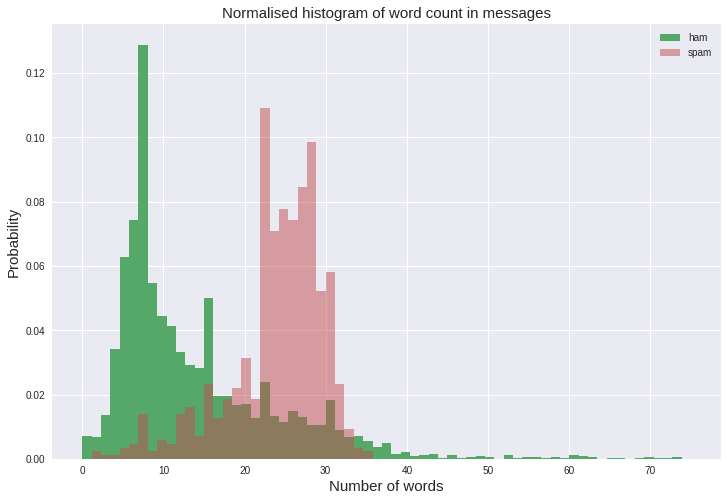

In [11]:
# Plot distributions of word counts for spam vs ham messages

plt.figure(figsize=(12,8))
plt.hist(dist_ham, bins=65, range=[0,75], color=pal[1], normed=True, label='ham')
plt.hist(dist_spam, bins=65, range=[0, 75], color=pal[2], normed=True, alpha=0.5, label='spam')
plt.title('Normalised histogram of word count in messages', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('# Summary statistics for word count of ham vs spam messages')
print('mean-ham  {:.2f}   mean-spam {:.2f} \nstd-ham   {:.2f}   std-spam   {:.2f} \nmin-ham    {:.2f}   min-ham    {:.2f} \nmax-ham  {:.2f}   max-spam  {:.2f}'.format(dist_ham.mean(), 
                         dist_spam.mean(), dist_ham.std(), dist_spam.std(), dist_ham.min(), dist_spam.min(), dist_ham.max(), dist_spam.max()))

As expected, spam messages tend to have more words than ham messages (which corresponds to our results about character count). Eyeballing the plots, it seems that character count might be a better predictor.

Note also that the **maximum number of words for spam messages is only 35, whereas for ham messages it's 171. We can see from the plot that quite a few messages have over 36 words**, so that'd likely be a feature our classifier can pick up later on.

## Simple Classifier: XGBoost

Before we move on to semantic analysis, let's try using the features we have so far - character count and word count - to predict whether a message is spam.

So far I've been exploring the whole dataset (which some might consider cheating :P), but now that we want to test the accuracy of classifiers we'll split the data into training and test datasets.

### Add features to our dataframe

In [12]:
# Add our features to our dataframe
df['word_count'] = pd.Series(df['sms_text'].tolist()).astype(str).apply(lambda x: len(x.split(' ')))
df['char_count'] = pd.Series(df['sms_text'].tolist()).astype(str).apply(len)

# For some models the target label has to be int, float or bool
df['is_spam'] = (df['label'] == 'spam')

# Check things worked as expected
df.head()

,label,sms_text,word_count,char_count,is_spam
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,False
1,ham,Ok lar... Joking wif u oni...,6,29,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,True
3,ham,U dun say so early hor... U c already then say...,11,49,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,False


### Split data into training, validation and test datasets

In [13]:
from sklearn.model_selection import train_test_split

X = df[['word_count', 'char_count']]
y = df[['is_spam']]

# Split data into training and test sets
# TODO: Might want to split such that train and test sets have equal proportion of spam messages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split some training data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Train XGBoost classifier 

In [14]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-error:0.077139	valid-error:0.067265
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[10]	train-error:0.077139	valid-error:0.067265
[20]	train-error:0.076858	valid-error:0.067265
[30]	train-error:0.073773	valid-error:0.070628
[40]	train-error:0.070687	valid-error:0.071749
[50]	train-error:0.075175	valid-error:0.073991
Stopping. Best iteration:
[0]	train-error:0.077139	valid-error:0.067265



We have a **pretty good validation error of around 7% based only on word and character count**.

In [15]:
from sklearn.metrics import accuracy_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.910313901345


## Word Cloud
Which are the most common words in spam messages and ham messages? We can then use **frequencies of certain words as features**.

In [16]:
# To avoid cheating, we will first split the data into train and test sets and then only
# count top words for our training data.

X = df
y = df[['is_spam']]

# Split data into training and test sets
# TODO: Might want to split such that train and test sets have equal proportion of spam messages
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ham_messages_train = pd.Series(X_train[X_train['label'] == 'ham']['sms_text'].tolist()).astype(str)
spam_messages_train = pd.Series(X_train[X_train['label'] == 'spam']['sms_text'].tolist()).astype(str)

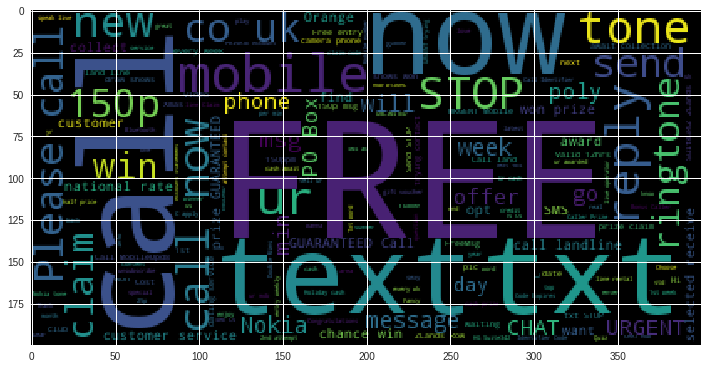

In [17]:
from wordcloud import WordCloud
# WordCloud automatically excludes stop words

# Draw word cloud for spam messages
spam_messages_one_string = " ".join(spam_messages_train.astype(str))
spam_cloud = WordCloud().generate(spam_messages_one_string)
plt.figure(figsize=(12,8))
plt.imshow(spam_cloud)

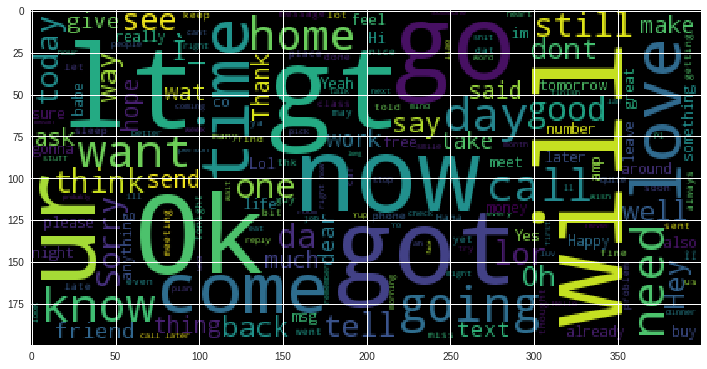

In [18]:
# Draw word cloud for ham messages
ham_messages_one_string = " ".join(ham_messages_train.astype(str))
ham_cloud = WordCloud().generate(ham_messages_one_string)
plt.figure(figsize=(12,8))
plt.imshow(ham_cloud)

As you might expect, spam messages frequently include words such as *FREE, now, mobile, call, text*, and *txt*. The words used frequently in ham messages seem more general, e.g. *Ok, ur*. We can see that messages like 'got to go' and 'will ...' also seem common, which is intuitive.

It's odd why the words lt and gt are so common. I'm not aware that people often abbreviate e.g. later as *lt* and get as *gt*. To me they seem like abbreviations for *less than* and *greater than*.

*Now* is common in both ham and spam messages, so checking whether that word is in a message probably won't be too effective in distinguishing between the two.

The next step is to get a **more precise count of which words are the most frequent**.

In [19]:
from collections import Counter
ham_words_list = ham_messages_one_string.split()
total_ham_words = len(ham_words_list)
print("Total number of words in ham messages: ", total_ham_words)
ham_words_dict = Counter(ham_words_list).most_common()
ham_words_dict[:25]

Total number of words in ham messages:  54545


[('to', 1252),
 ('I', 1164),
 ('you', 1121),
 ('the', 803),
 ('a', 779),
 ('i', 585),
 ('in', 582),
 ('and', 575),
 ('u', 524),
 ('is', 505),
 ('my', 486),
 ('me', 419),
 ('of', 396),
 ('for', 387),
 ('that', 306),
 ('your', 300),
 ('at', 279),
 ('have', 276),
 ('on', 274),
 ('it', 274),
 ('not', 255),
 ('are', 246),
 ('&lt;#&gt;', 234),
 ('be', 233),
 ('will', 229)]

In [20]:
spam_words_list = spam_messages_one_string.split()
total_spam_words = len(spam_words_list)
print("Total number of words in spam messages: ", total_spam_words)
spam_words_dict = Counter(spam_words_list).most_common()
spam_words_dict[:25]

Total number of words in spam messages:  14280


[('to', 487),
 ('a', 288),
 ('your', 159),
 ('or', 151),
 ('call', 143),
 ('the', 141),
 ('2', 138),
 ('for', 136),
 ('you', 126),
 ('is', 115),
 ('Call', 110),
 ('on', 109),
 ('have', 103),
 ('from', 95),
 ('and', 92),
 ('ur', 86),
 ('&', 82),
 ('with', 81),
 ('4', 74),
 ('FREE', 74),
 ('of', 69),
 ('You', 66),
 ('mobile', 65),
 ('are', 63),
 ('claim', 62)]

We can see that many of these words listed are **stop words** and so may not be as useful in classifying whether messages are spam or not.

Stop words are words like *the, you, and, is* which do not contain important significance to be used in search queries. For example, the most used word in both ham and spam messages was *to*.

To create a dictionary of the most frequently used non-stopwords, we will manually add non-stopwords to a dictionary instead of using `Counter()`.

In [21]:
from nltk.corpus import stopwords
from collections import defaultdict
import operator

stopwords = set(stopwords.words("english"))

ham_words_lowercase = ham_messages_one_string.lower().split()

ham_words_nostop = []
for word in ham_words_lowercase:
    if word not in stopwords:
        ham_words_nostop.append(word)

ham_words_freq = Counter(ham_words_nostop).most_common()
ham_words_freq[:25]

[('u', 730),
 ("i'm", 298),
 ('&lt;#&gt;', 234),
 ('get', 225),
 ('2', 224),
 ('ur', 199),
 ('go', 196),
 ('.', 188),
 ('got', 188),
 ('come', 173),
 ('call', 172),
 ('like', 169),
 ('know', 164),
 ('?', 153),
 ('good', 150),
 ('...', 141),
 ('going', 135),
 ('ok', 128),
 ('4', 126),
 ("i'll", 126),
 ('love', 121),
 ('still', 120),
 ('want', 119),
 ('time', 119),
 ('one', 116)]

Now we know why *lt, gt* appeared as frequently used words in ham messages - they were the emoticon >< !

In [22]:
spam_words_lowercase = spam_messages_one_string.lower().split()

spam_words_nostop = []
for word in spam_words_lowercase:
    if word not in stopwords:
        spam_words_nostop.append(word)

spam_words_freq = Counter(spam_words_nostop).most_common()
spam_words_top25 = spam_words_freq[:25]
spam_words_top25

[('call', 269),
 ('free', 146),
 ('2', 138),
 ('ur', 115),
 ('txt', 111),
 ('u', 92),
 ('claim', 88),
 ('mobile', 88),
 ('text', 82),
 ('&', 82),
 ('reply', 80),
 ('4', 74),
 ('get', 71),
 ('stop', 71),
 ('now!', 56),
 ('new', 54),
 ('nokia', 51),
 ('send', 49),
 ('cash', 48),
 ('prize', 47),
 ('please', 45),
 ('win', 44),
 ('-', 43),
 ('contact', 40),
 ('per', 38)]

In [23]:
spam_words_top25_list = [tuple[0] for tuple in spam_words_top25]
ham_words_top25 = [tuple[0] for tuple in ham_words_freq[:25]]

In [24]:
spam_words_top25_pruned = []
for word in spam_words_top25_list:
    if word not in ham_words_top25:
        spam_words_top25_pruned.append(word)
        
ham_words_top25_pruned = []
for word in ham_words_top25:
    if word not in spam_words_top25_list:
        ham_words_top25_pruned.append(word)

print("Number of non-duplicates in each list: ", len(spam_words_top25_pruned))

Number of non-duplicates in each list:  19


Now we will naively include whether-or-not-a-message-includes-these-words as features.

In [25]:
for word in (spam_words_top25_pruned + ham_words_top25_pruned):
    df[word] = (word in df['sms_text'])
    X_train[word] = (word in X_train['sms_text'])
    X_test[word] = (word in X_test['sms_text'])
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,label,sms_text,word_count,char_count,is_spam,free,txt,claim,mobile,text,...,good,...,going,ok,i'll,love,still,want,time,one
0,ham,"Go until jurong point, crazy.. Available only ...",20,111,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,6,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,155,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,11,49,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,61,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
del X_train['sms_text']
del X_train['label']
del X_test['sms_text']
del X_test['label']

# Split some training data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [27]:
X_train.head()

,word_count,char_count,is_spam,free,txt,claim,mobile,text,&,reply,...,good,...,going,ok,i'll,love,still,want,time,one
1270,19,81,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3019,15,72,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4224,21,115,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4416,42,200,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
564,34,146,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [28]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-error:0	valid-error:0
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[10]	train-error:0	valid-error:0
[20]	train-error:0	valid-error:0
[30]	train-error:0	valid-error:0
[40]	train-error:0	valid-error:0
[50]	train-error:0	valid-error:0
Stopping. Best iteration:
[0]	train-error:0	valid-error:0



In [29]:
# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy:  1.0


Oh, the **validation and test accuracies are 1.0**. Nice!